In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error
import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy.linalg as la
import warnings
import tqdm
from myGeniousSARIMA import myModelSARIMA
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from dateutil.relativedelta import relativedelta
from configuration import CSV_PATH, ps, Ps, qs, Qs, s, ds, Ds, predict_len, const, my_Ps, my_Qs, my_ps, my_qs
import numpy as np

warnings.filterwarnings('ignore')

In [2]:
def prepare_dataset(path):
    dataset = pd.read_csv(path, delimiter=',')
    dataset['Change'] = dataset['close'] - dataset['open']
    changed_dataset = dataset[['date', 'Change']]
    return changed_dataset

def compress_date(data):
    data['date'] = data['date'].map(lambda date: date[:-3])
    new_data = data.groupby(['date']).agg({
        "Change": "sum",
        })
    new_data.index = pd.to_datetime(new_data.index, utc=True, format="%Y-%m")
    new_data['Change'] = new_data['Change'].map(lambda x: x + const)
    return new_data

In [3]:
def show_series(data):
    data.plot()

In [4]:
def test_static(data):
    test = sm.tsa.adfuller(data['Change'])
    print('adf: ', test[0])
    print('p-value: ', test[1])
    print('critical values: ', test[4])
    if test[0] > test[4]['5%']:
        print("Есть единичные корни, ряд не стационарен")
    else:
        print("Единичных корней нет, ряд стационарен")

In [5]:
def show_acf_pacf(data):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(data.values.squeeze(), lags=150, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(data, lags=135, ax=ax2)

In [6]:
def find_best_parameters(parameters_list, data_part): 
    best_aic = float("inf")
    results = []
    for param in tqdm.tqdm(parameters_list):
        try:
            model = sm.tsa.statespace.SARIMAX(
                data_part['Change'], 
                order=(param[0], param[5], param[1]), 
                seasonal_order=(param[2], param[6], param[3], param[4])
            ).fit(disp=-1)
        except ValueError:
            print('wrong parameters:', param)
            continue
        except la.LinAlgError:
            print('wrong parameters:', param)
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
    return results, best_model, best_aic, best_param

def print_results(results):
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    print(result_table.sort_values(by = 'aic', ascending=True).head())

def show_best_model_result(best_model):
    plt.figure(figsize=(15,15))

    plt.subplot(211)
    best_model.resid[0:].plot()

    ax = plt.subplot(212)
    sm.graphics.tsa.plot_acf(best_model.resid[0:].values.squeeze(), lags=48, ax=ax);

adf:  -8.02703502852557
p-value:  2.0044792968098067e-12
critical values:  {'1%': -3.4540935579190495, '5%': -2.8719934111688965, '10%': -2.5723401594120388}
Единичных корней нет, ряд стационарен


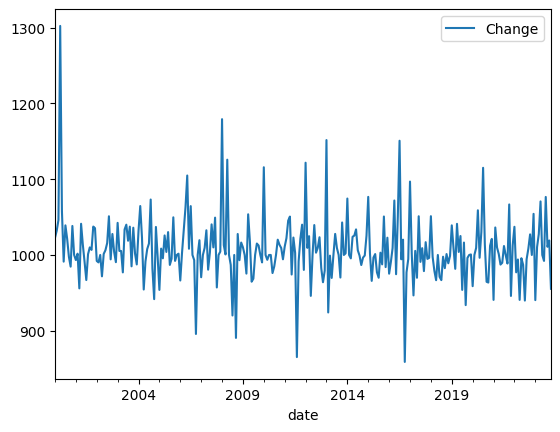

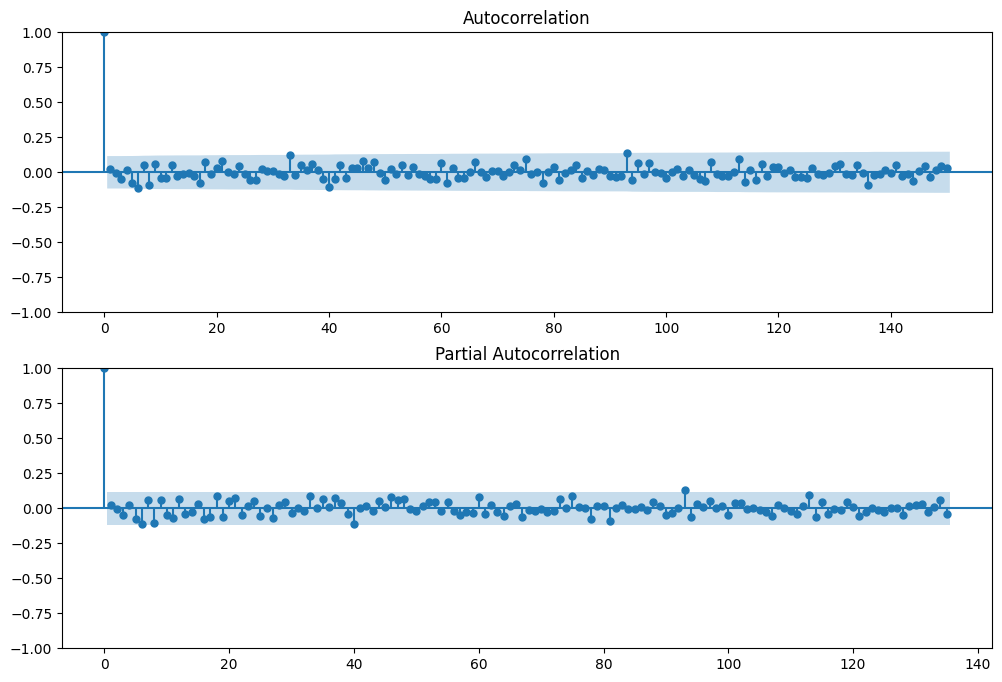

In [7]:
data = compress_date(prepare_dataset(CSV_PATH))
show_series(data)
test_static(data)
show_acf_pacf(data)

In [8]:
learn_data_model = data[:'2020-11']

parameters = product(ps, qs, Ps, Qs, s, ds, Ds)
parameters_list = list(parameters)

results, best_model, best_aic, best_param = find_best_parameters(parameters_list, learn_data_model)

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [03:58<00:00, 14.89s/it]

wrong parameters: (7, 8, 2, 2, 14, 0, 0)


In [9]:
print_results(results)
print(best_model.summary())

                parameters          aic
0   (5, 6, 1, 1, 14, 0, 0)  2626.613316
13  (7, 8, 1, 2, 14, 0, 0)  2636.479057
4   (5, 8, 1, 1, 14, 0, 0)  2638.773785
9   (7, 6, 1, 2, 14, 0, 0)  2638.849978
10  (7, 6, 2, 1, 14, 0, 0)  2640.386734
                                      SARIMAX Results                                       
Dep. Variable:                               Change   No. Observations:                  251
Model:             SARIMAX(5, 0, 6)x(1, 0, [1], 14)   Log Likelihood               -1299.307
Date:                              Sat, 21 Oct 2023   AIC                           2626.613
Time:                                      20:41:14   BIC                           2675.970
Sample:                                  01-01-2000   HQIC                          2646.476
                                       - 11-01-2020                                         
Covariance Type:                                opg                                         
                

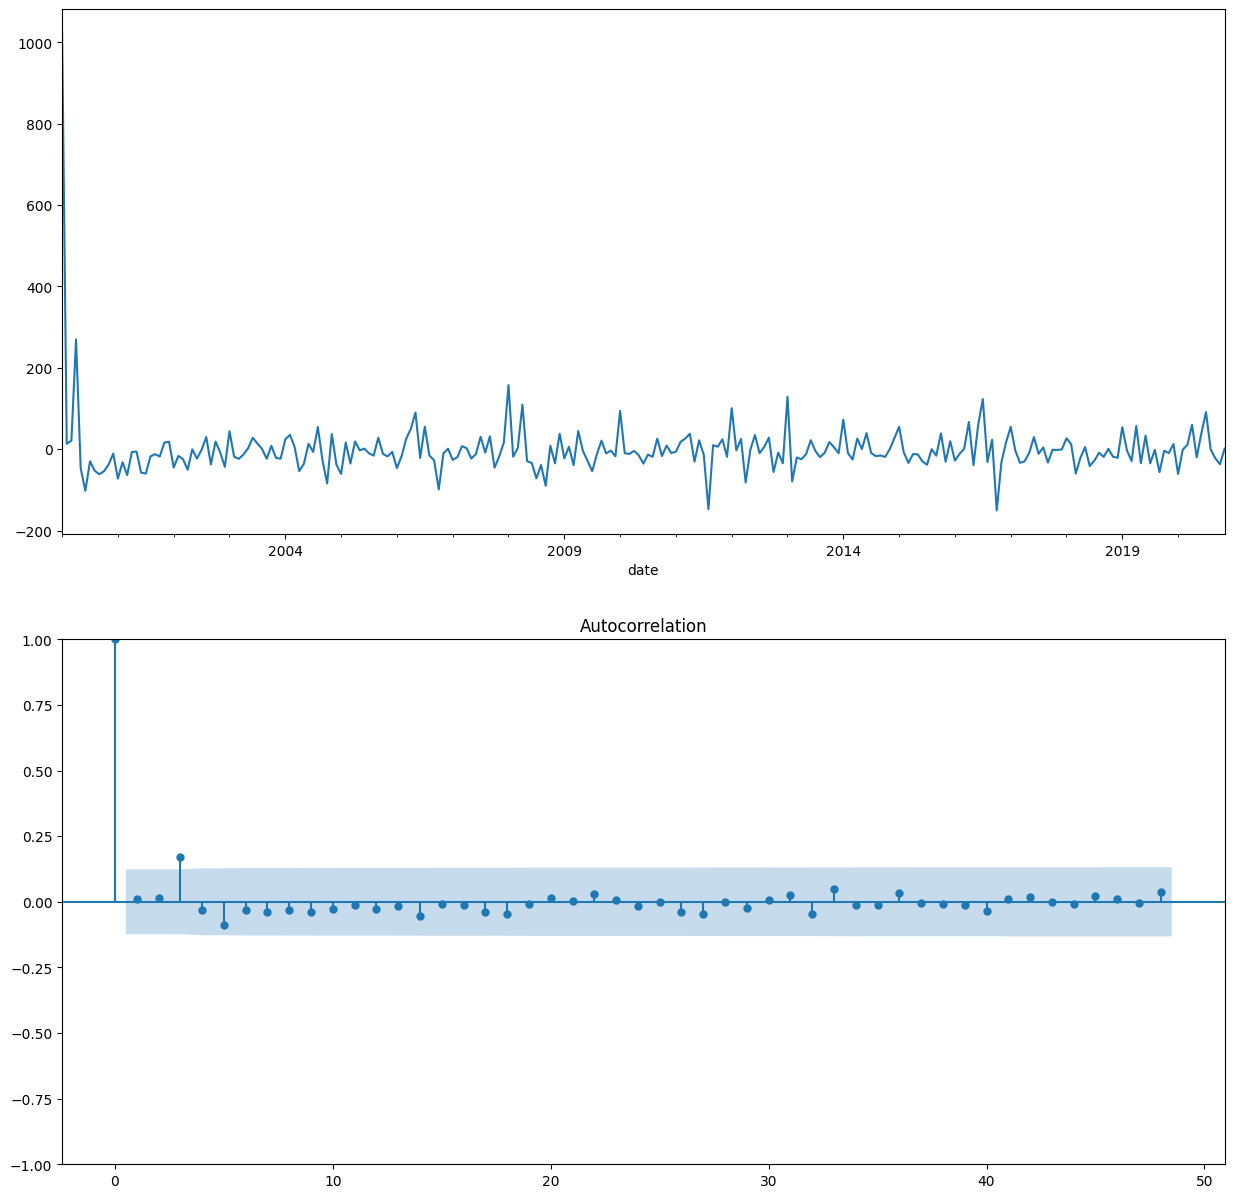

In [10]:
show_best_model_result(best_model)

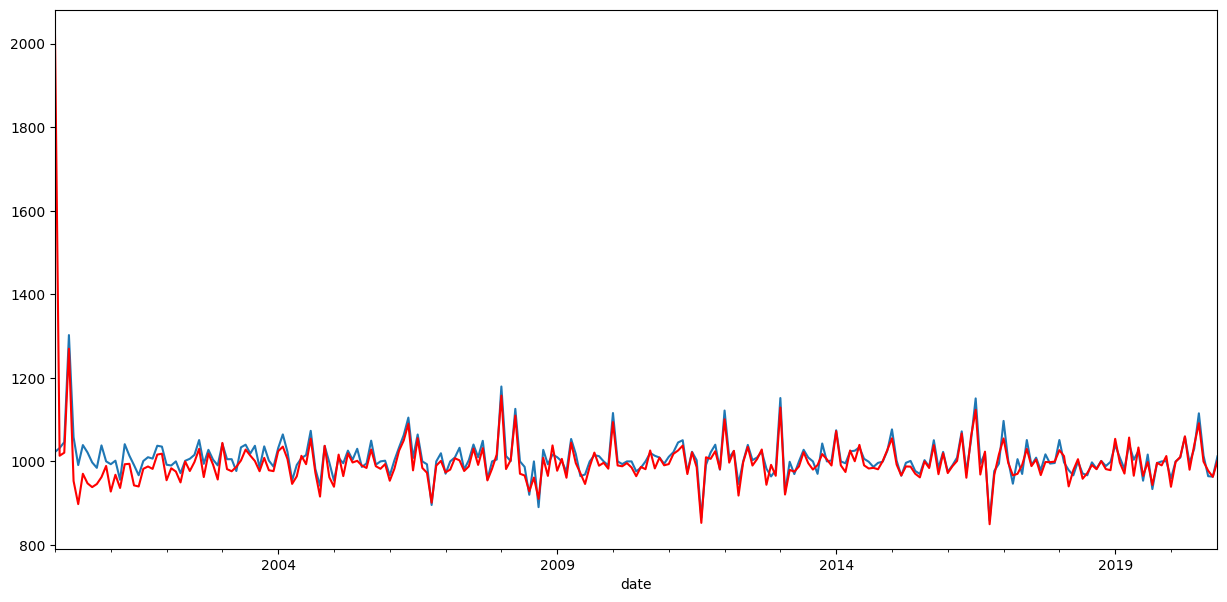

In [11]:
learn_data_model['Model'] = best_model.resid[0:].map(lambda x: x + const)
plt.figure(figsize=(15,7))
learn_data_model['Change'][:].plot()
learn_data_model['Model'][:].plot(c='r');

In [12]:
def predict_from_lib(model):
    new_close_value = data
    future_date = [
        datetime.datetime.strptime("2020-11-01", "%Y-%m-%d") + relativedelta(months=x)
        for x in range(0, predict_len)
    ]
    predict = model.forecast(predict_len)
    predict.index = pd.to_datetime(future_date, utc=True, format="%Y-%m")

    new_close_value['Predict'] = predict
    
    return mean_absolute_percentage_error(new_close_value['Change'].tail(predict_len), predict)

def print_model(best_predict_model):
    new_close_value = data
    future_date = [
        datetime.datetime.strptime("2020-11-01", "%Y-%m-%d") + relativedelta(months=x)
        for x in range(0, predict_len)
    ]
    predict = best_predict_model.forecast(predict_len)
    predict.index = pd.to_datetime(future_date, utc=True, format="%Y-%m")
    
    new_close_value['Predict'] = predict
    new_close_value['Model'] = best_predict_model.resid[0:].map(lambda x: x + const)

    plt.figure(figsize=(15,7))
    
    new_close_value['Change'].plot()
    new_close_value['Model'].plot(c='r');
    new_close_value['Predict'].plot(c='g');

def find_best_predict_model():
    lowest_error, best_params, best_predict_model = -1, [], best_model
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    best_results = result_table.sort_values(by = 'aic', ascending=True)
    searching_model_params = best_results['parameters']
    for model_param in tqdm.tqdm(searching_model_params):
        try:
            model = sm.tsa.statespace.SARIMAX(
                learn_data_model['Change'], 
                order=(model_param[0], model_param[5], model_param[1]), 
                seasonal_order=(model_param[2], model_param[6], model_param[3], model_param[4])
            ).fit(disp=-1)
        except ValueError:
            print('wrong parameters:', model_param)
            continue
        except la.LinAlgError:
            print('wrong parameters:', model_param)
            continue
        tmp = predict_from_lib(model)
        if lowest_error == -1 or tmp < lowest_error:
            lowest_error = tmp
            best_params = model_param
            best_predict_model = model
    print(lowest_error, best_params)
    print_model(best_predict_model)
    return best_predict_model

100%|██████████| 15/15 [03:42<00:00, 14.81s/it]


0.025034315717536317 (5, 6, 2, 1, 14, 0, 0)


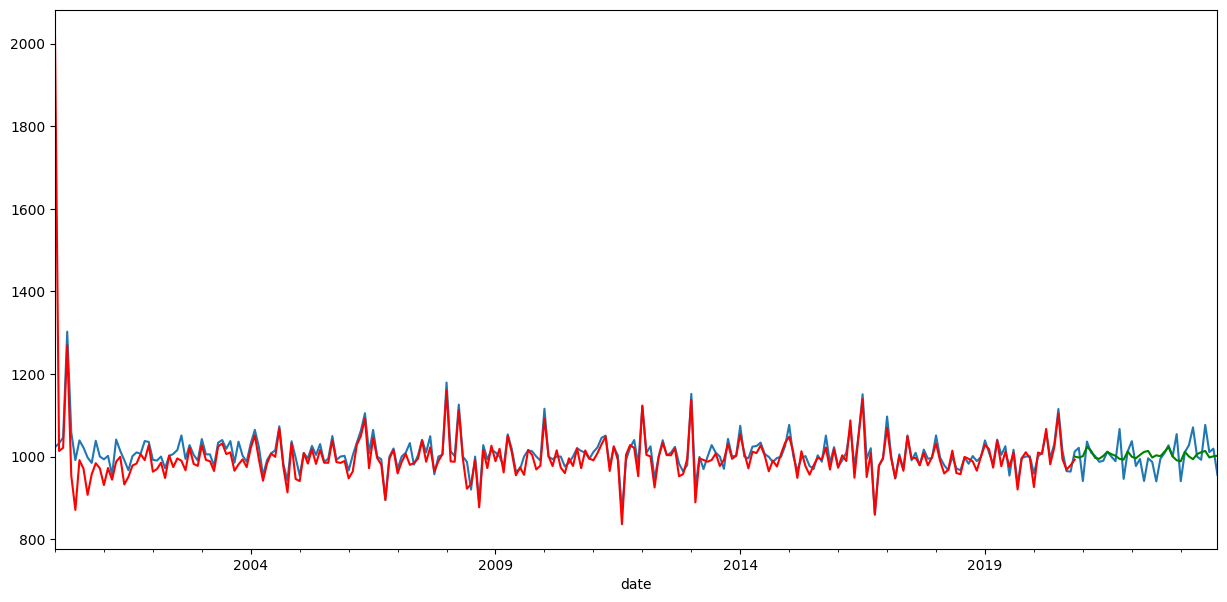

In [13]:
best_lib_model = find_best_predict_model()

In [14]:
def print_my_model(model):
    new_close_value = data
    future_date = [
        datetime.datetime.strptime("2020-11-01", "%Y-%m-%d") + relativedelta(months=x)
        for x in range(0, predict_len)
    ]
    
    past_date = [
        datetime.datetime.strptime("2000-01-01", "%Y-%m-%d") + relativedelta(months=x)
        for x in range(0, 251)
    ]
    predict = pd.Series(myModelSARIMA.predict(model, predict_len))
    model_values =  pd.Series(model.model_data)

    model_values.index = pd.to_datetime(past_date, utc=True, format="%Y-%m")
    predict.index = pd.to_datetime(future_date, utc=True, format="%Y-%m")

    new_close_value['Predict'] = predict
    new_close_value['Model'] = model_values

    plt.figure(figsize=(15,7))
    
    new_close_value['Change'].plot()
    new_close_value['Model'].plot(c='r');
    new_close_value['Predict'].plot(c='g');

def predict_from_my_SARIMA(model):
    new_close_value = data
    future_date = [
        datetime.datetime.strptime("2020-11-01", "%Y-%m-%d") + relativedelta(months=x)
        for x in range(0, predict_len)
    ]
    predict = pd.Series(myModelSARIMA.predict(model, predict_len))
    predict.index = pd.to_datetime(future_date, utc=True, format="%Y-%m")
    
    return mean_absolute_percentage_error(new_close_value['Change'].tail(predict_len), predict)
    

def find_best_parameters_my_SARIMA(parameters_list):
    lowest_error, best_params, best_predict_model = -1, [], best_model
    for param in tqdm.tqdm(parameters_list):
        try:
            model = myModelSARIMA
            myModelSARIMA.mgSARIMA(model, data=learn_data_model['Change'], order=[param[0], param[5], param[1]], seasonal_order=[param[2], param[6], param[3], param[4]])
            
        except ValueError:
            print('wrong parameters:', param)
            continue
        tmp = predict_from_my_SARIMA(model)
        if lowest_error == -1 or tmp < lowest_error:
            lowest_error = tmp
            best_params = param
            best_predict_model = model
    print(lowest_error, best_params)
    print_my_model(best_predict_model)
    return best_predict_model

100%|██████████| 2800/2800 [06:18<00:00,  7.41it/s]


0.02420790070528474 (9, 2, 14, 9, 14, 0, 0)


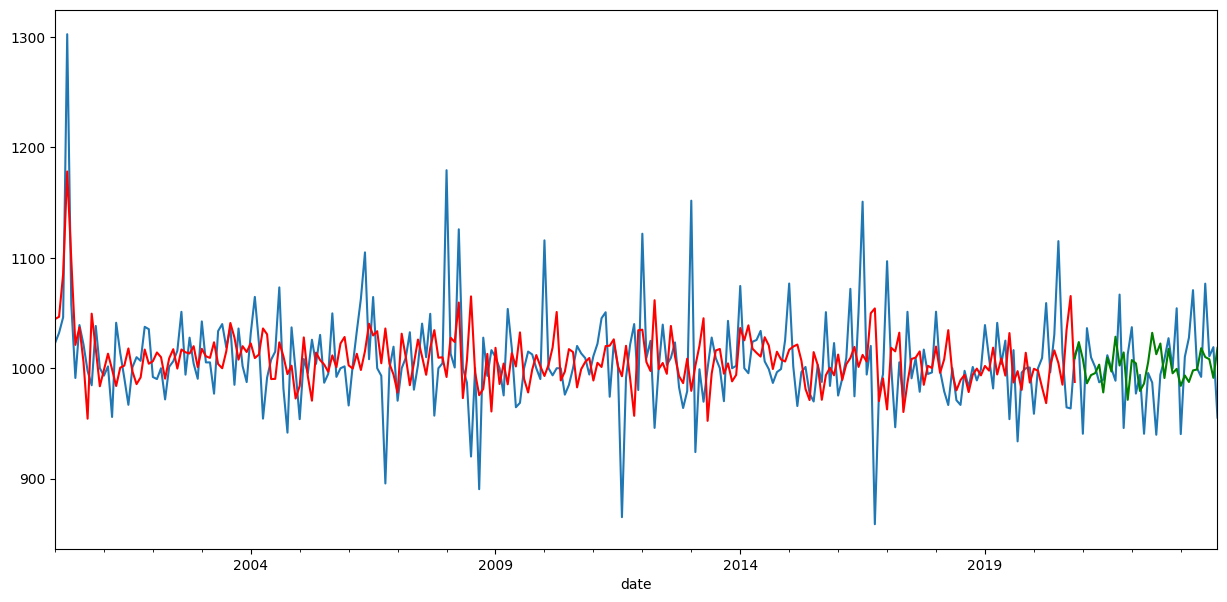

In [15]:
parameters_my_SARIMA = product(my_ps, my_qs, my_Ps, my_Qs, s, ds, Ds)
parameters_list_my_SARIMA = list(parameters_my_SARIMA)
best_my_model = find_best_parameters_my_SARIMA(parameters_list_my_SARIMA)

In [16]:
def print_two_predicts(lib_model, my_model):
    new_close_value = data['2020-11':]
    future_date = [
        datetime.datetime.strptime("2020-11-01", "%Y-%m-%d") + relativedelta(months=x)
        for x in range(0, predict_len)
    ]

    my_predict = pd.Series(myModelSARIMA.predict(my_model, predict_len))
    my_predict.index = pd.to_datetime(future_date, utc=True, format="%Y-%m")

    lib_predict = lib_model.forecast(predict_len)
    lib_predict.index = pd.to_datetime(future_date, utc=True, format="%Y-%m")

    new_close_value['MyPredict'] = my_predict
    new_close_value['LibPredict'] = lib_predict

    plt.figure(figsize=(15,7))
    
    new_close_value['Change'].plot()
    new_close_value['MyPredict'].plot(c='g');
    new_close_value['LibPredict'].plot(c='r');

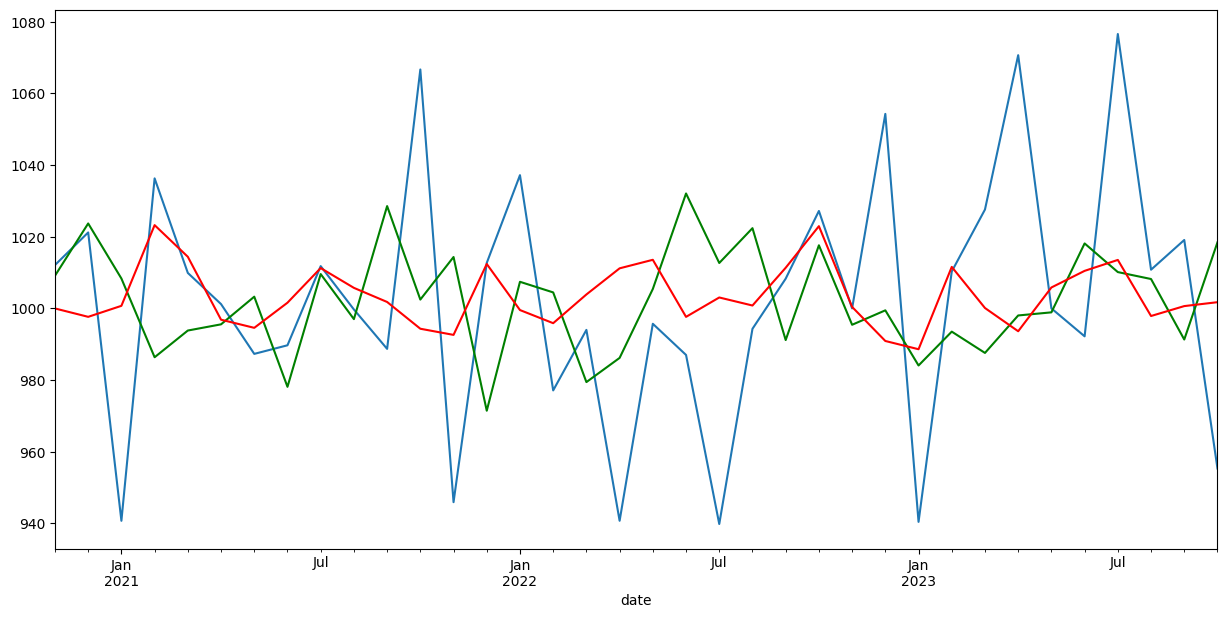

In [17]:
print_two_predicts(best_lib_model, best_my_model)